## 1-head self-attention implementation

In [ ]:
%pip install datasets nltk
%pip install torchtext==0.17.0
%pip install -U portalocker>=2.0.0

# https://pypi.org/project/torchtext/

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.5/755.5 MB 1.3 MB/s eta 0:00:00
   ━━━

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import nltk
nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 1. Data preparation

In [ ]:
from datasets import load_dataset

imdb = load_dataset("imdb")
train_data, test_data = imdb['train'], imdb['test']

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.81k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
#import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator


tokenizer = get_tokenizer("basic_english")
vocab_size = 20000

def yield_tokens(data_iter):
    for data in data_iter:
        yield tokenizer(data["text"])

vocab = build_vocab_from_iterator(yield_tokens(train_data),
                                  min_freq = 3,
                                  max_tokens=vocab_size,
                                  specials=["<pad>", "<s>", "<unk>"])
vocab.set_default_index(vocab["<unk>"])

In [ ]:
seq_length = 200
text_pipeline = lambda x: vocab(tokenizer(x))

def collate_batch(batch, seq_length=seq_length):
    text_list, label_list = [], []
    for sample in batch:
        label_list.append(sample['label'])

        text_processed = text_pipeline(sample['text'])[:seq_length]
        if len(text_processed) < seq_length:
            pad_size = seq_length - len(text_processed) -1
            text_processed = [vocab["<pad>"]] * pad_size + [vocab["<s>"]] + text_processed
        text_list.append(text_processed)

    input_ids = torch.tensor(text_list, dtype=torch.int64)
    labels = torch.tensor(label_list, dtype=torch.int64)
    return (input_ids, labels)

In [ ]:
from torch.utils.data import DataLoader
batch_size = 32

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, collate_fn=collate_batch, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, collate_fn=collate_batch, drop_last=True)

# 2. Model

In [ ]:
class MyMultiheadAttention(nn.Module):
    def __init__(self, embed_dim):
        super(MyMultiheadAttention, self).__init__()
        self.embed_dim = embed_dim

    def forward(self, query, key, value):
        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.embed_dim ** 0.5)
        attention_weights = F.softmax(scores, dim=-1)
        output = torch.matmul(attention_weights, value)

        return output

class TransformerTextCls(nn.Module):
    def __init__(self, vocab_size, max_length, embed_dim, dropout, device):
        super().__init__()
        self.word_emb = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)
        self.attn = MyMultiheadAttention(embed_dim=embed_dim)
        self.fc = nn.Linear(in_features=200*32, out_features=2)

    def forward(self, x):
        output = self.word_emb(x)
        query, key, value = output, output, output
        attn_output = self.attn(query, key, value)

        output = nn.Flatten()(output)
        output = self.fc(output)
        return output

In [ ]:
max_length = seq_length #200
embed_dim = 32
ff_dim = 32
dropout = 0.1
model = TransformerTextCls(vocab_size, max_length, embed_dim, dropout, device)

# 3. Evaluate

In [ ]:
def evaluate(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            test_loss += loss.item()
            correct +=(predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    accuracy = 100* correct / total

    return test_loss, accuracy

# 4. Train

In [ ]:
max_epoch = 15
LR = 0.001
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

model.to(device)
for epoch in range(max_epoch):
    model.train()
    running_loss = 0.0
    running_correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        running_correct += (predicted == labels).sum().item()

        loss.backward()
        optimizer.step()

    epoch_loss =  running_loss / len(train_loader)
    epoch_accuracy = 100* running_correct / total
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)

    print(f"Epoch [{epoch + 1}/{max_epoch}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

Epoch [1/15], Loss: 0.8686, Accuracy: 58.07%, Test Loss: 0.8427, Test Accuracy: 62.10%
Epoch [2/15], Loss: 0.6097, Accuracy: 73.94%, Test Loss: 0.8221, Test Accuracy: 68.12%
Epoch [3/15], Loss: 0.4486, Accuracy: 81.72%, Test Loss: 0.8279, Test Accuracy: 71.15%
Epoch [4/15], Loss: 0.3226, Accuracy: 87.10%, Test Loss: 0.8943, Test Accuracy: 72.33%
Epoch [5/15], Loss: 0.2224, Accuracy: 91.22%, Test Loss: 0.9497, Test Accuracy: 73.44%
Epoch [6/15], Loss: 0.1400, Accuracy: 94.63%, Test Loss: 1.0368, Test Accuracy: 73.96%
Epoch [7/15], Loss: 0.0852, Accuracy: 97.11%, Test Loss: 1.1096, Test Accuracy: 74.36%
Epoch [8/15], Loss: 0.0502, Accuracy: 98.49%, Test Loss: 1.1897, Test Accuracy: 74.61%
Epoch [9/15], Loss: 0.0293, Accuracy: 99.26%, Test Loss: 1.2509, Test Accuracy: 74.93%
Epoch [10/15], Loss: 0.0183, Accuracy: 99.59%, Test Loss: 1.3168, Test Accuracy: 75.26%
Epoch [11/15], Loss: 0.0139, Accuracy: 99.68%, Test Loss: 1.4418, Test Accuracy: 74.60%
Epoch [12/15], Loss: 0.0087, Accuracy: 99

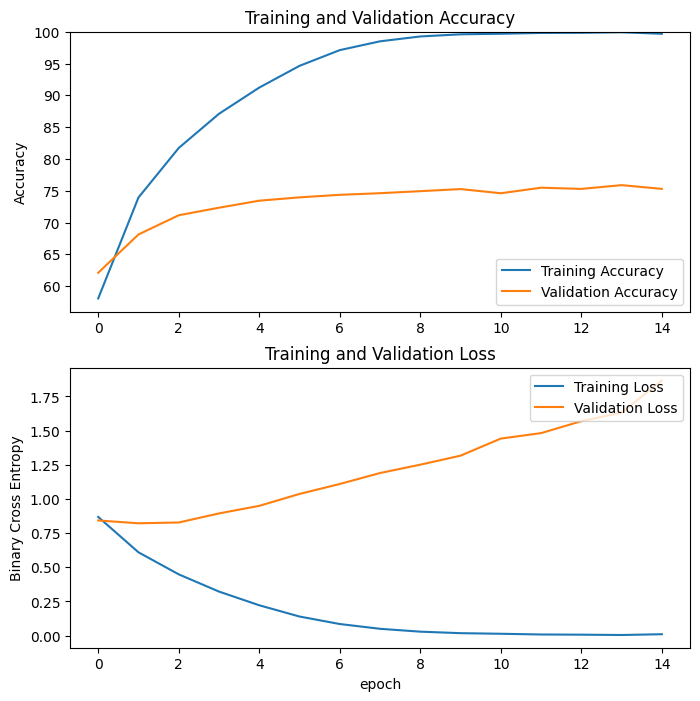

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),100])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()